In [1]:
import pandas as pd
import numpy as np

In [2]:
# Specify the file path
url = 'https://raw.githubusercontent.com/ISSS623-AHA/ISSS623_2024/main/Lecture%202/RRT.csv'

# Read the CSV file into a DataFrame
rrt = pd.read_csv(url)

# Display the structure of the DataFrame
print(rrt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         3000 non-null   int64
 1   Age        3000 non-null   int64
 2   RRT        3000 non-null   int64
 3   AKIN       3000 non-null   int64
 4   SOFA       3000 non-null   int64
 5   Mortality  3000 non-null   int64
dtypes: int64(6)
memory usage: 140.8 KB
None


# 1. Data Exploration

In [3]:
# Let's see what is the proportion of patients who received RRT

# Calculate the counts and proportions of each group
group_counts = rrt['RRT'].value_counts()
total_patients = rrt['RRT'].count()
group_proportions = group_counts / total_patients

# Create a new DataFrame to store the counts and proportions
report_df = pd.DataFrame({
    'Count': group_counts,
    'Proportion': group_proportions
}).reset_index().rename(columns={'index': 'RRT'})
report_df

,RRT,Count,Proportion
0,0,2709,0.903
1,1,291,0.097


In [4]:
# Next we see what is the counts of mortality across each RRT type via contingency table
contingency_table = pd.crosstab(rrt['RRT'], rrt['Mortality'])
print(contingency_table)

# We can also calculate the proportion of mortality counts across each row sum(axis=1), div (..., axis=0)
proportion_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)
print(proportion_table)

# There seems to be higher proportion of deaths with RRT. Obviously other confounders are not considered in this univariate analysis

Mortality     0   1
RRT                
0          2629  80
1           243  48
Mortality         0         1
RRT                          
0          0.970469  0.029531
1          0.835052  0.164948


In [5]:
# we can also look at the differences of mean Age, AKIN and SOFA scores (assuming they are all continuous variables) across Mortality
mean_values = rrt.groupby('RRT')[['Age', 'AKIN', 'SOFA']].mean()
mean_values

# we can see that indeed, there are quite obvious differences between these two groups of patients.
# These confounders should be accounted for in accessing whether RRT can reduce mortality.

,Age,AKIN,SOFA
RRT,,,
0,59.750461,0.054633,5.656331
1,64.378007,0.443299,10.962199


In [6]:
# We can see the selection bias across AKIN scores for the proportion of patients selected for RRT
# Creating a contingency table for AKIN scores across RRT selection
akin_rrt_contingency = pd.crosstab(rrt['AKIN'], rrt['RRT'])
print(akin_rrt_contingency)

# Calculate the proportion of patients selected for RRT based on different AKIN scores
akin_rrt_proportion = akin_rrt_contingency.div(akin_rrt_contingency.sum(axis=1), axis=0)
print(akin_rrt_proportion)

# Higher AKIN scores have higher proportion of RRT => We can see that indeed, patients in worse conditions were more likely to receive RRT.

RRT      0    1
AKIN           
0     2629  230
1       29   14
2       34   26
3       17   21
RRT          0         1
AKIN                    
0     0.919552  0.080448
1     0.674419  0.325581
2     0.566667  0.433333
3     0.447368  0.552632


# 2. Estimate the Propensity Score Model

In [7]:
rrt.columns

Index(['ID', 'Age', 'RRT', 'AKIN', 'SOFA', 'Mortality'], dtype='object')

In [8]:
import statsmodels.api as sm
# We use Logistic regression with covariate: 'Age', 'AKIN', 'SOFA'; Outcome is RRT. 'Mortality' is not used in the PSM equation.
# Define the covariates for propensity score estimation
covariates = ['Age', 'AKIN', 'SOFA']

# Fit the logistic regression model to estimate propensity scores
logit = sm.Logit(rrt['RRT'], sm.add_constant(rrt[covariates]))
result = logit.fit()

print(result.summary())



Optimization terminated successfully.
         Current function value: 0.194614
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    RRT   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2996
Method:                           MLE   Df Model:                            3
Date:                Tue, 09 Jul 2024   Pseudo R-squ.:                  0.3889
Time:                        00:47:07   Log-Likelihood:                -583.84
converged:                       True   LL-Null:                       -955.32
Covariance Type:            nonrobust   LLR p-value:                1.013e-160
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.7772      0.597    -16.380      0.000     -10.947      -8.607
Age            0.0299      0.

In [9]:
# Propensity score column is generated from the fitted logit function
rrt['propensity_score'] = result.predict(sm.add_constant(rrt[covariates]))
# describe the propensity score column
rrt['propensity_score'].describe()
# All data will have a propensity score estimated based on the covariates and outcome 'RRT'

count    3000.000000
mean        0.097000
std         0.176888
min         0.000094
25%         0.003609
50%         0.027721
75%         0.096050
max         0.978584
Name: propensity_score, dtype: float64

In [10]:
import matplotlib.pyplot as plt
# Separate treated and control groups from the cohort of 3000 patients
treated = rrt[rrt['RRT'] == 1]
control = rrt[rrt['RRT'] == 0]

print(treated.describe())
print(control.describe())

                ID         Age    RRT        AKIN        SOFA   Mortality  \
count   291.000000  291.000000  291.0  291.000000  291.000000  291.000000   
mean   1574.831615   64.378007    1.0    0.443299   10.962199    0.164948   
std     877.046849   12.103921    0.0    0.928132    2.690074    0.371773   
min       5.000000   28.000000    1.0    0.000000    3.000000    0.000000   
25%     791.000000   56.500000    1.0    0.000000    9.000000    0.000000   
50%    1654.000000   64.000000    1.0    0.000000   11.000000    0.000000   
75%    2328.500000   74.000000    1.0    0.000000   13.000000    0.000000   
max    2996.000000   94.000000    1.0    3.000000   17.000000    1.000000   

       propensity_score  
count        291.000000  
mean           0.424011  
std            0.290133  
min            0.002377  
25%            0.155989  
50%            0.404274  
75%            0.670772  
max            0.978584  
                ID          Age     RRT         AKIN         SOFA  \
cou

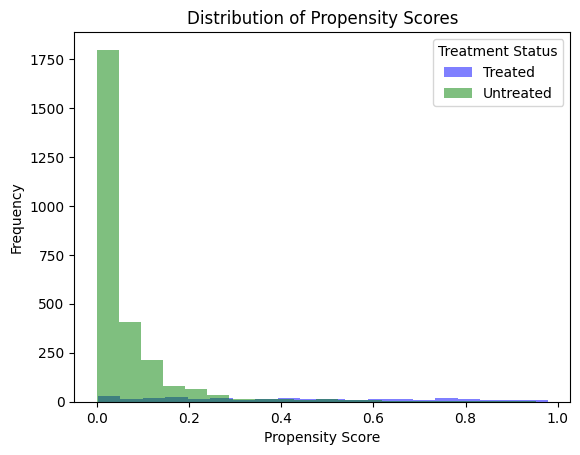

In [11]:
plt.hist(treated['propensity_score'], bins=20, alpha=0.5, label='Treated', color='blue')
plt.hist(control['propensity_score'], bins=20, alpha=0.5, label='Untreated', color='green')
plt.legend(title='Treatment Status')

# Adding plot titles and labels
plt.title('Distribution of Propensity Scores')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')

# Show the plot
plt.show()

Overview before matching


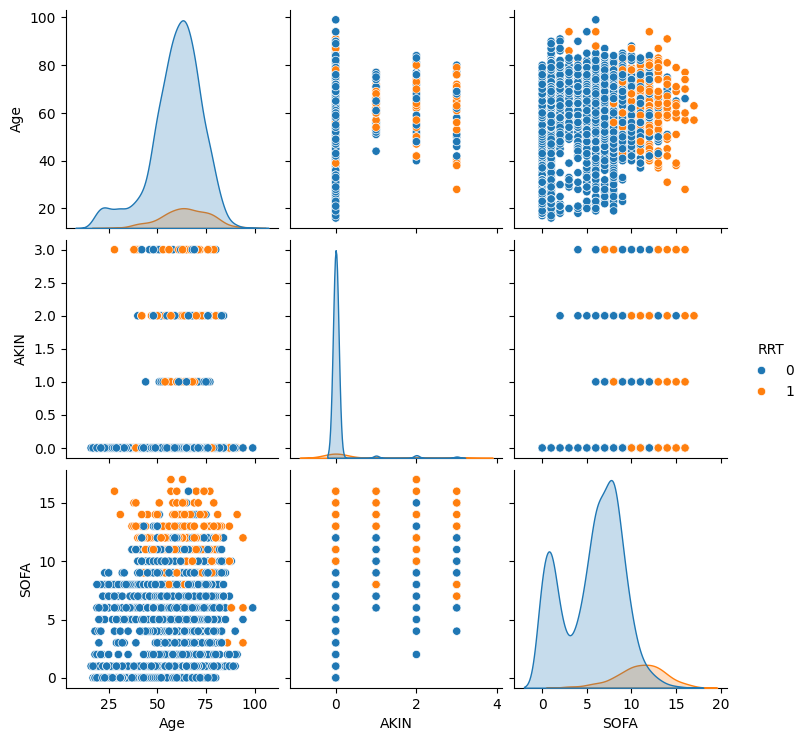

In [12]:
import seaborn as sns
# Overview of distributions across covariates before matching
sns.pairplot(data = rrt[['Age', 'AKIN', 'SOFA', 'RRT']], hue = 'RRT')
print('Overview before matching')

# 3. Match the subjects for Treated and Control groups based on propensity scores


In [13]:
from sklearn.neighbors import NearestNeighbors

# Nearest neighbour matching with replacement (Controls may be repeated - introduce bias)
# Use Nearest Neighbors to match based on propensity scores
# n_neighbors=1 specifies that we want to find the single nearest neighbor for each point in the treated group.
nn = NearestNeighbors(n_neighbors=1)

# The fit method trains the nearest neighbors model on the control group using the propensity_score column.
# In this case, it memorizes the propensity scores of the control group, as KNN is a non-parametric and lazy learning algorithm.
nn.fit(control[['propensity_score']])

# The kneighbors method finds the nearest neighbor for each point in the treated group based on their propensity scores.
distances, indices = nn.kneighbors(treated[['propensity_score']])
matched_control_indices = indices.flatten()

# Create a DataFrame for matched controls
# control.iloc[matched_control_indices] selects the rows from the control DataFrame
matched_control = control.iloc[matched_control_indices].copy()

# matched_control.reset_index()
matched_control
# # range(len(matched_control)) generates a sequence of numbers from 0 to the number of matched controls minus one (nature of Python).
# # this code assigns these numbers as match IDs to the matched controls.
# # This helps in identifying the matches later.
# matched_control['match_id'] = range(len(matched_control))

,ID,Age,RRT,AKIN,SOFA,Mortality,propensity_score
1468,1469,73,0,0,10,0,0.265861
2768,2769,66,0,0,11,0,0.361919
765,766,49,0,0,10,0,0.150185
747,748,72,0,0,9,0,0.154003
1000,1001,77,0,0,10,0,0.289842
...,...,...,...,...,...,...,...
908,909,67,0,2,13,1,0.787483
2418,2419,83,0,0,11,1,0.485287
1857,1858,48,0,0,11,0,0.248783
1577,1578,56,0,0,8,0,0.055213


In [14]:
# Matching Controls to Treated (Controls are not repeated)
nn = NearestNeighbors(n_neighbors=1)

# Fit the model on the entire control group initially
nn.fit(control[['propensity_score']])

matched_indices_NR = []
available_controls = np.array(control.index)  # Keep track of available control indices

for treated_index, treated_row in treated.iterrows():
    # Find the nearest available control
    # distances, indices = nn.kneighbors([treated_row['propensity_score']])
    # reshape it to be 2D
    input_feature = np.array([treated_row['propensity_score']]).reshape(1, -1)

    # Now, use this reshaped array as the input to kneighbors()
    distances, indices = nn.kneighbors(input_feature)
    # print("Distances:", distances)
    # print("Indices:", indices)

    # Since control indices may have been reduced, map back to original
    control_index = available_controls[indices[0][0]]

    # Append the original control index to matched indices
    matched_indices_NR.append(control_index)

    # Remove the matched control index from available controls
    available_controls = np.delete(available_controls, np.where(available_controls == control_index))

    # Update the NearestNeighbors model to exclude the matched control
    if len(available_controls) > 0:  # Ensure there are still controls available
        nn.fit(control.loc[available_controls, ['propensity_score']])
    else:
        break  # No more controls to match

# Create a DataFrame for matched controls
matched_control_NR = control.loc[matched_indices_NR].copy()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature n

In [15]:
# Combine matched treated and control patients (291 X 2 patients altogether)
matched_df_repl = pd.concat([treated, matched_control], axis=0)
print(matched_df_repl.RRT.value_counts())

# Show number of unique Controls matched with Treated
print(matched_df_repl.groupby('RRT')['ID'].nunique())
# Only 144 unique controls are matched with replacement.
# Matching with replacement may result in over-representation.
# Some control subjects might be used multiple times, potentially over-representing those subjects' characteristics in the control group.
# May also result in Biased Estimates - introduce dependency between treated subjects
# If the same controls are used multiple times, it may bias the estimates of treatment effects.


RRT
1    291
0    291
Name: count, dtype: int64
RRT
0    144
1    291
Name: ID, dtype: int64


In [16]:
# Combine matched treated and control patients (291 X 2 patients altogether)
matched_df_NR = pd.concat([treated, matched_control_NR], axis=0)
print(matched_df_NR.RRT.value_counts())

# Show number of unique Controls matched with Treated
print(matched_df_NR.groupby('RRT')['ID'].nunique())

# Matching without replacement can help in bias reduction. However, it may be challenging to find a match
# without replacement also mean that the next better match may not give a good match quality.

RRT
1    291
0    291
Name: count, dtype: int64
RRT
0    291
1    291
Name: ID, dtype: int64


# 4. Check Balance of Covariates in the matched samples (Match Quality)

In [17]:
# Summarize characteristics of the matched samples
matched_summary = matched_df_NR[covariates + ['RRT']].groupby('RRT').describe()

# Display the summary
print("\nMatched Sample Characteristics (Matching without replacement):")
print(matched_summary)


Matched Sample Characteristics (Matching without replacement):
       Age                                                       AKIN  \
     count       mean        std   min   25%   50%   75%   max  count   
RRT                                                                     
0    291.0  64.869416  10.379529  37.0  59.0  65.0  72.0  88.0  291.0   
1    291.0  64.378007  12.103921  28.0  56.5  64.0  74.0  94.0  291.0   

               ...             SOFA                                       \
         mean  ...  75%  max  count       mean       std  min  25%   50%   
RRT            ...                                                         
0    0.288660  ...  0.0  3.0  291.0  10.065292  2.016962  3.0  9.0  10.0   
1    0.443299  ...  0.0  3.0  291.0  10.962199  2.690074  3.0  9.0  11.0   

                 
      75%   max  
RRT              
0    11.0  16.0  
1    13.0  17.0  

[2 rows x 24 columns]


Overview After Matching (Matching without Replacement)


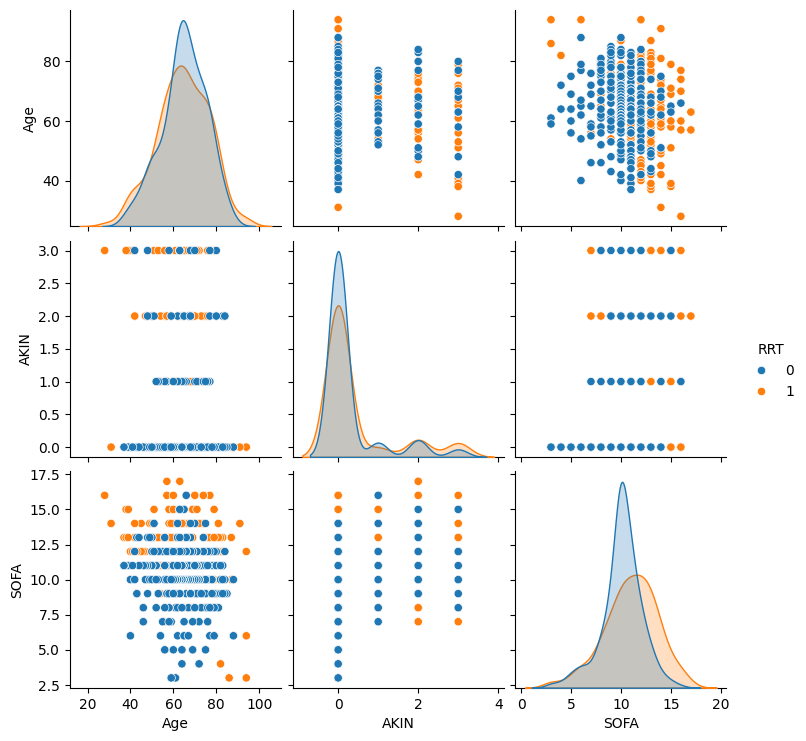

In [18]:
# Overview of distributions after matching (No replacement)
sns.pairplot(data = matched_df_NR[['Age', 'AKIN', 'SOFA', 'RRT']], hue = 'RRT')
print('Overview After Matching (Matching without Replacement)')

Overview After Matching (Matching with Replacement)


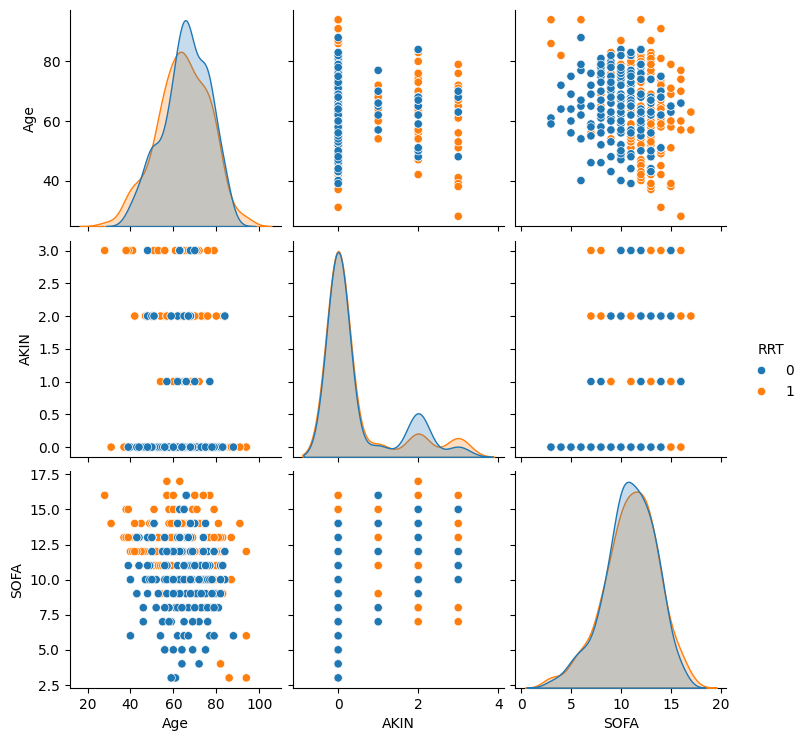

In [19]:
# Overview of distributions after matching
sns.pairplot(data = matched_df_repl[['Age', 'AKIN', 'SOFA', 'RRT']], hue = 'RRT')
print('Overview After Matching (Matching with Replacement)')

# Gives closer match, but only 144 unique patients out of 199 in the Control Group

In [20]:
# Here we can check the unmatched controls. We only look at matching without replacement (minimize bias)
# Filter set of unmatched controls
matched_indices = set(matched_df_NR['ID'])
# Filter the original DataFrame to exclude rows that are in the matched indices
unmatched_controls = rrt[~rrt.index.isin(matched_indices)]['ID']

In [21]:
unmatched_controls.nunique()
# originally there were 2,709 Control (no RRT). Unmatched controls is thus 2,709 - 291 = 2,418

2418

In [22]:
rrt.columns

Index(['ID', 'Age', 'RRT', 'AKIN', 'SOFA', 'Mortality', 'propensity_score'], dtype='object')

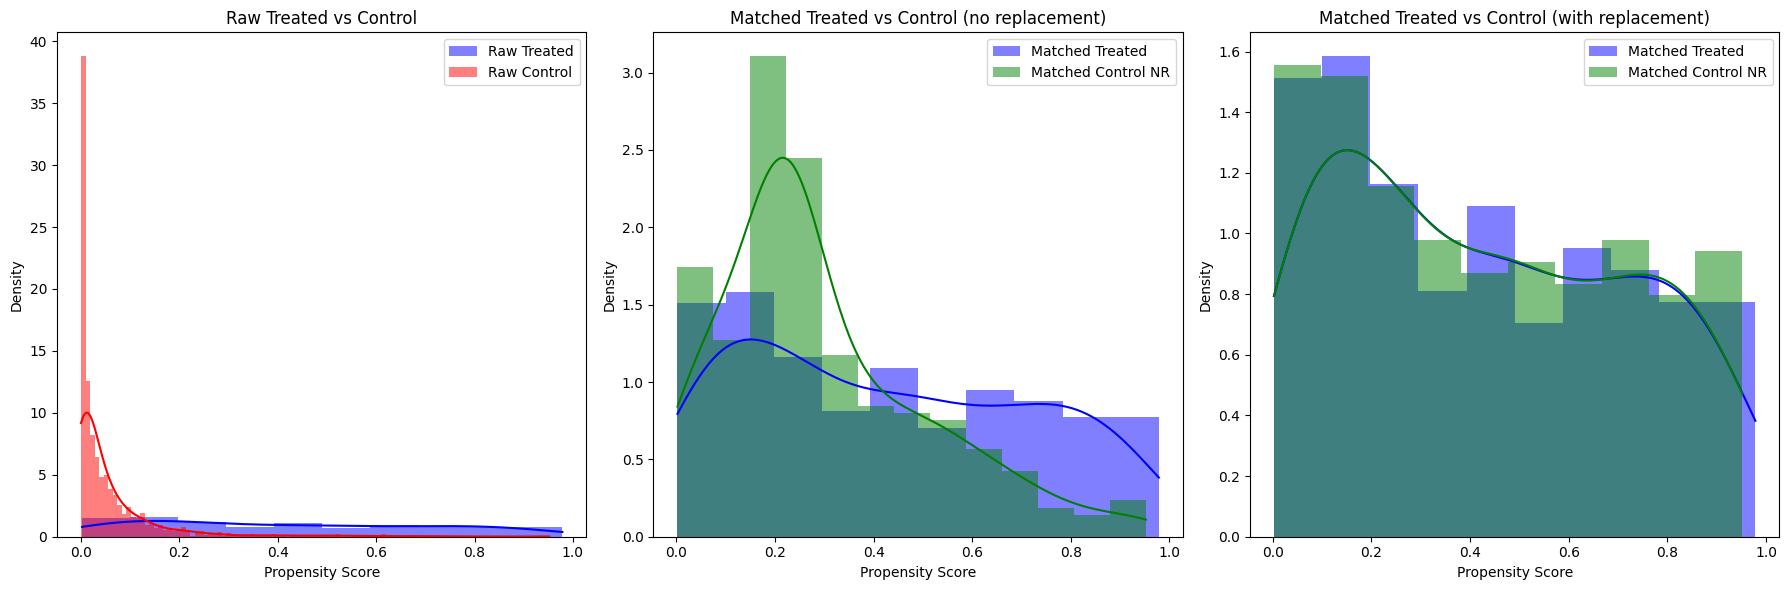

In [23]:
# Plot histogram of propensity scroe for Raw Treated vs Control and Matched Treated vs Control
# Set up the matplotlib figure
plt.figure(figsize=(18, 6))

# First subplot for Raw Treated vs Control
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
sns.histplot(treated['propensity_score'], color="blue", label='Raw Treated', kde=True, stat="density", linewidth=0)
sns.histplot(control['propensity_score'], color="red", label='Raw Control', kde=True, stat="density", linewidth=0)
plt.title('Raw Treated vs Control')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()

# Second subplot for Matched Treated vs Control (No Replacement)
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
sns.histplot(treated['propensity_score'], color="blue", label='Matched Treated', kde=True, stat="density", linewidth=0)
sns.histplot(matched_control_NR['propensity_score'], color="green", label='Matched Control NR', kde=True, stat="density", linewidth=0)
plt.title('Matched Treated vs Control (no replacement)')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()

# Third subplot for Matched Treated vs Control (With Replacement)
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 2nd subplot
sns.histplot(treated['propensity_score'], color="blue", label='Matched Treated', kde=True, stat="density", linewidth=0)
sns.histplot(matched_control['propensity_score'], color="green", label='Matched Control NR', kde=True, stat="density", linewidth=0)
plt.title('Matched Treated vs Control (with replacement)')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


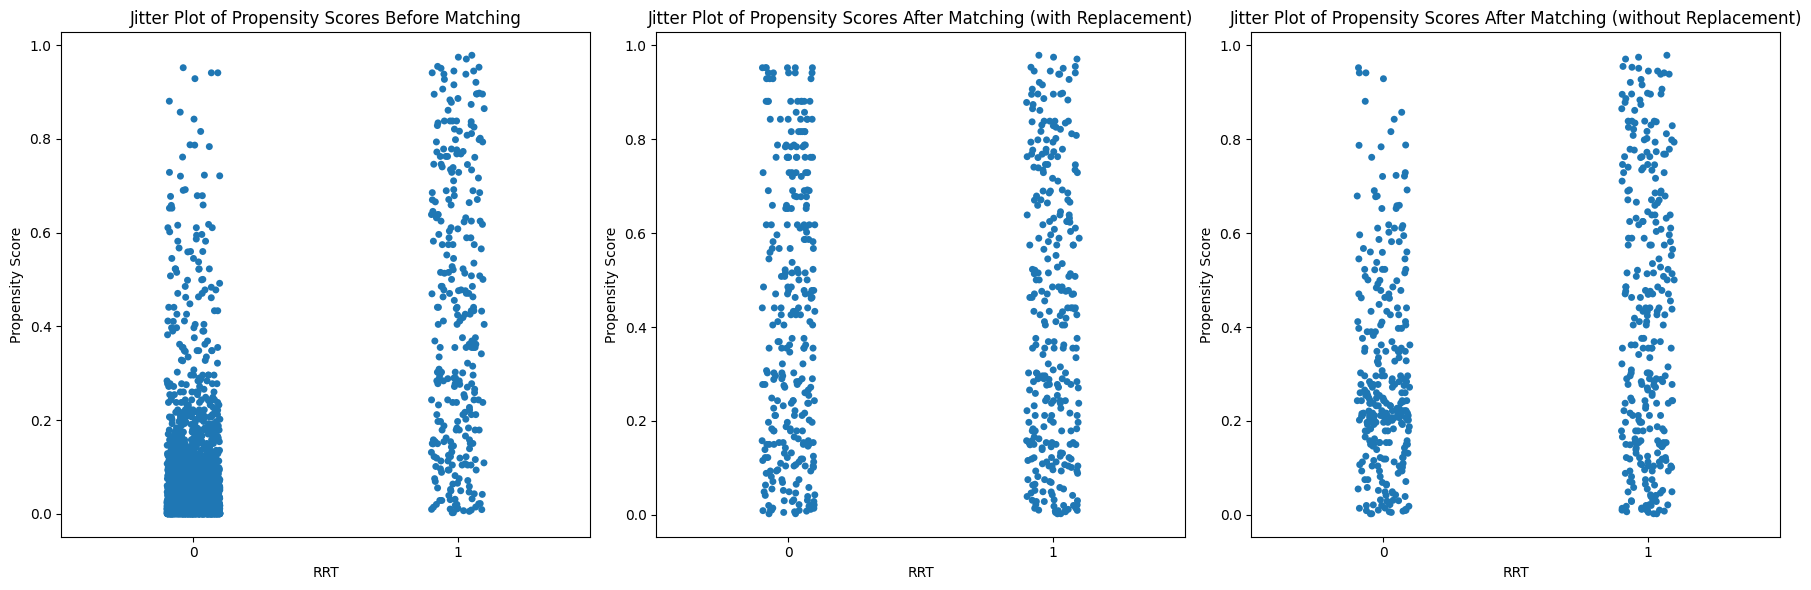

In [24]:
# We can also look at the jitter plot of the propensity scores.
plt.figure(figsize=(18, 6))

# Jitter plot before matching
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
sns.stripplot(x='RRT', y='propensity_score', data=rrt, jitter=True, edgecolor='none')
plt.title('Jitter Plot of Propensity Scores Before Matching')
plt.xlabel('RRT')
plt.ylabel('Propensity Score')

# Jitter plot after matching with replacement
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
sns.stripplot(x='RRT', y='propensity_score', data=matched_df_repl, jitter=True, edgecolor='none')
plt.title('Jitter Plot of Propensity Scores After Matching (with Replacement)')
plt.xlabel('RRT')
plt.ylabel('Propensity Score')

# Jitter plot after matching without replacement
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
sns.stripplot(x='RRT', y='propensity_score', data=matched_df_NR, jitter=True, edgecolor='none')
plt.title('Jitter Plot of Propensity Scores After Matching (without Replacement)')
plt.xlabel('RRT')
plt.ylabel('Propensity Score')

# Show the plot
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

# 5. Evaluating the Average Treatment Effects based on Matched Pairs

In [25]:
matched_df_repl.columns

Index(['ID', 'Age', 'RRT', 'AKIN', 'SOFA', 'Mortality', 'propensity_score'], dtype='object')

In [26]:
# Average Treatment effects for Treated vs Control (Matching with replacement)
P_est = matched_df_repl[['Mortality','RRT']].groupby(by = ['RRT']).aggregate([np.mean, np.var, np.std, 'count'])
print(P_est)
# Here the Mean for binary outcomes represent the probability of 'Mortality'; variance is computed as *p(1-p)* where p: probability of Mortality

ATE_estimate = P_est['Mortality']['mean'][1]-P_est['Mortality']['mean'][0]
print("Average Treatment Effect (with replacement):", ATE_estimate)
# A reduction of 19.6% chance of "Mortality"

    Mortality                          
         mean       var       std count
RRT                                    
0    0.381443  0.236758  0.486578   291
1    0.164948  0.138215  0.371773   291
Average Treatment Effect (with replacement): -0.21649484536082472


In [27]:
# Average Treatment effects for Treated vs Control (Matching without replacement)
P_est_NR = matched_df_NR[['Mortality','RRT']].groupby(by = ['RRT']).aggregate([np.mean, np.var, np.std, 'count'])
print(P_est_NR)
# Here the Mean for binary outcomes represent the probability of 'Mortality'; variance is computed as *p(1-p)* where p: probability of Mortality
ATE_estimate_NR = P_est_NR['Mortality']['mean'][1]-P_est_NR['Mortality']['mean'][0]
print("Average Treatment Effect (without replacement):", ATE_estimate_NR)
# A reduction of 2.4% chance of "Mortality"

    Mortality                          
         mean       var       std count
RRT                                    
0    0.185567  0.151653  0.389427   291
1    0.164948  0.138215  0.371773   291
Average Treatment Effect (without replacement): -0.020618556701030938


In [28]:
# Average Treatment effects (Matching with replacement): Computing the 95% Confidence Intervals
# Extract means, variances, and counts
mean_treated = P_est['Mortality']['mean'][1]
mean_control = P_est['Mortality']['mean'][0]
var_treated = P_est['Mortality']['var'][1]
var_control = P_est['Mortality']['var'][0]
count_treated = P_est['Mortality']['count'][1]
count_control = P_est['Mortality']['count'][0]

# Calculate Standard Error
SE = np.sqrt((var_treated / count_treated) + (var_control / count_control))

# Calculate 95% Confidence Interval
z = 1.96  # Z-value for 95% confidence; for a normal distribution, the z-value is 1.96
CI_lower = ATE_estimate - z * SE
CI_upper = ATE_estimate + z * SE

print("ATE Estimate (with replacement):", ATE_estimate)
print("95% Confidence Interval:", (CI_lower, CI_upper))


ATE Estimate (with replacement): -0.21649484536082472
95% Confidence Interval: (-0.28685224362025075, -0.1461374471013987)


In [29]:
# Average Treatment effects (Matching without replacement): Computing the 95% Confidence Intervals
# Extract means, variances, and counts
mean_treated = P_est_NR['Mortality']['mean'][1]
mean_control = P_est_NR['Mortality']['mean'][0]
var_treated = P_est_NR['Mortality']['var'][1]
var_control = P_est_NR['Mortality']['var'][0]
count_treated = P_est_NR['Mortality']['count'][1]
count_control = P_est_NR['Mortality']['count'][0]

# Calculate Standard Error
SE = np.sqrt((var_treated / count_treated) + (var_control / count_control))

CI_lower = ATE_estimate_NR - z * SE
CI_upper = ATE_estimate_NR + z * SE

print("ATE Estimate (without replacement):", ATE_estimate_NR)
print("95% Confidence Interval:", (CI_lower, CI_upper))


ATE Estimate (without replacement): -0.020618556701030938
95% Confidence Interval: (-0.08247857787753998, 0.041241464475478114)
